In [1]:
# import warnings
# warnings.filterwarnings("ignore")

import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import scipy
import scipy.signal
import os, os.path

from datetime import date
import datetime
import time

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb

import sys

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')
import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

start_time = time.time()

In [3]:
data_dir = "/Users/hn/Documents/01_research_data/" + \
           "remote_sensing/01_NDVI_TS/70_Cloud/00_Eastern_WA_withYear/2Years/"

param_dir = "/Users/hn/Documents/00_GitHub/Ag/remote_sensing/parameters/"

In [4]:
####################################################################################
###
###      Parameters                   
###
####################################################################################

SF_year = 2017
indeks = "EVI"

In [5]:
f_name = "Eastern_WA_" + str(SF_year) + "_70cloud_selectors.csv"
a_df = pd.read_csv(data_dir + f_name, low_memory=False)

##################################################################
##################################################################
####
####  plots has to be exact. So, we need 
####  to filter out NASS, and filter by last survey date
####
##################################################################
##################################################################

a_df = a_df[a_df['county']== "Grant"] # Filter Grant
# a_df = rc.filter_out_NASS(a_df) # Toss NASS
# a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year


# Pipeline

   
   1. Read the data
   2. Remove outlliers and jumps
   3. Regularize
   4. Fill Gaps
   5. Smoothen
   6. Find peaks and troughs 
   7. Find SOS and EOS using NDVI ratio of White and TIMESAT.

## 1. Read the data 
(Extract one field)

In [6]:
one_field = a_df[a_df.ID == "100426_WSDA_SF_2017"].copy()

# one_field = one_field[one_field.image_year == 2017].copy()

#
# sort the time series
#
one_field.sort_values(by=['image_year', 'doy'], inplace=True)

#
# reset the damn index to avoid problems if loc and iloc.
#
one_field.reset_index(drop=True, inplace=True)
one_field = one_field[one_field['EVI'].notna()]

## add proper date columns to make plotting easier 

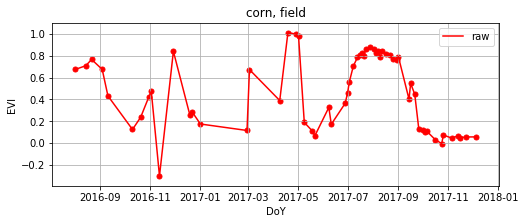

In [9]:
one_field['human_system_start_time'] = pd.to_datetime(one_field['image_year'] * 1000 + \
                                                      one_field['doy'], format='%Y%j')

one_field['Date'] = pd.to_datetime(one_field.human_system_start_time.values).values

fig, ax = plt.subplots(figsize=(8,3));
plot_title = one_field.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=25, c='r')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

## 2. Remove outliers and jumps

#### 2a. Remove outliers

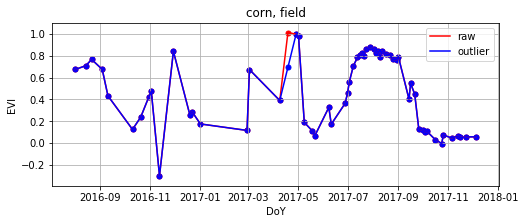

In [8]:
cleaned_field = rc.interpolate_outliers_EVI_NDVI(outlier_input = one_field , given_col = indeks)
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]


ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=25, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [10]:
outlierRemoved_EVI_values = cleaned_field['EVI']
outlierRemoved_EVI_time = cleaned_field['Date']

#### 2b. Remove Jumps

In [11]:
cleaned_field = rc.correct_big_jumps_1DaySeries(dataTMS_jumpie = cleaned_field, 
                                                give_col = indeks, 
                                                maxjump_perDay = 0.015)

In [12]:
outlierJumpRemoved_EVI_values = cleaned_field['EVI']
outlierJumpRemoved_EVI_time = cleaned_field['Date']

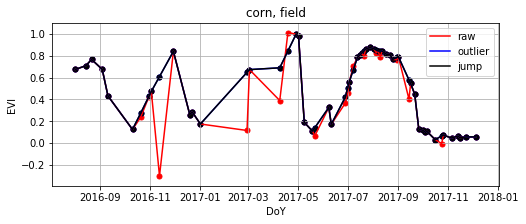

In [13]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=25, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'k', label="jump")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='k')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

### 3. Regularize

In [14]:
regular_window_size = 10 
regularized_TS = rc.regularize_movingWindow_windowSteps_2Yrs(one_field_df = cleaned_field, \
                                                             SF_yr = SF_year, \
                                                             veg_idxs = indeks, \
                                                             window_size = regular_window_size)

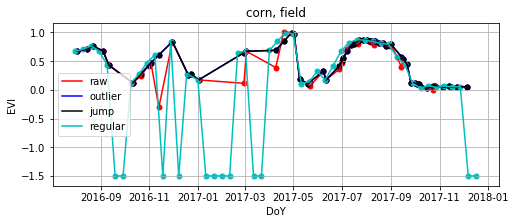

In [15]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]

ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=25, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'k', label="jump")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='k')

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'c', label="regular")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='c')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [16]:
regularized_EVI_values = regularized_TS['EVI']
regularized_EVI_time = regularized_TS['Date']

### 4. Fill Gaps

In [17]:
regularized_TS = rc.fill_theGap_linearLine(regular_TS = regularized_TS, V_idx = indeks, SF_year = 2017)

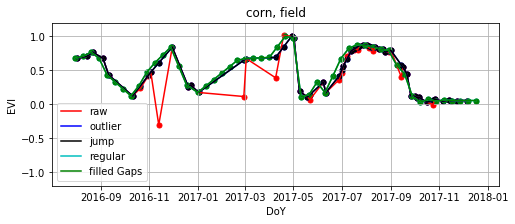

In [18]:
regularized_TS['human_system_start_time'] = pd.to_datetime(regularized_TS['image_year'] * 1000 + \
                                                           regularized_TS['doy'], format='%Y%j')

regularized_TS['Date'] = pd.to_datetime(regularized_TS.human_system_start_time.values).values


fig, ax = plt.subplots(figsize=(8,3));
plot_title = regularized_TS.CropTyp.unique()[0]


ax.plot(one_field['Date'], one_field['EVI'], c='r', label="raw")
ax.scatter(one_field['Date'], one_field['EVI'], marker='o', s=25, c='r')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c='b', label="outlier")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='b')

ax.plot(cleaned_field['Date'], cleaned_field['EVI'], c = 'k', label="jump")
ax.scatter(cleaned_field['Date'], cleaned_field['EVI'], marker='o', s=25, c='k')

ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'c', label="regular")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='c')


ax.plot(regularized_TS['Date'], regularized_TS['EVI'], c = 'g', label="filled Gaps")
ax.scatter(regularized_TS['Date'], regularized_TS['EVI'], marker='o', s=25, c='g')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.set_ylim([-1.2, 1.2])
ax.grid(True)

In [19]:
filledGaps_EVI_values = regularized_TS['EVI']
filledGaps_EVI_time = regularized_TS['Date']

# We only want to look at one year
We did it here, because our regularization function is written for 1.5 year 

### 5. Smoothen
This is done inside the plotting function. 
Maybe we can prodduce CSV fine for these and save in on the disk for further use.

## 6. Find peaks and troughs

### (a) MATLAB code converted

In [24]:
# crr_fld = clean_regularized_TS.copy()
# idx = indeks
# SG_params = [5, 1]
# SFYr = 2017
# ax = [0, 0]
# deltA = 0.4

In [21]:
clean_regularized_TS = regularized_TS

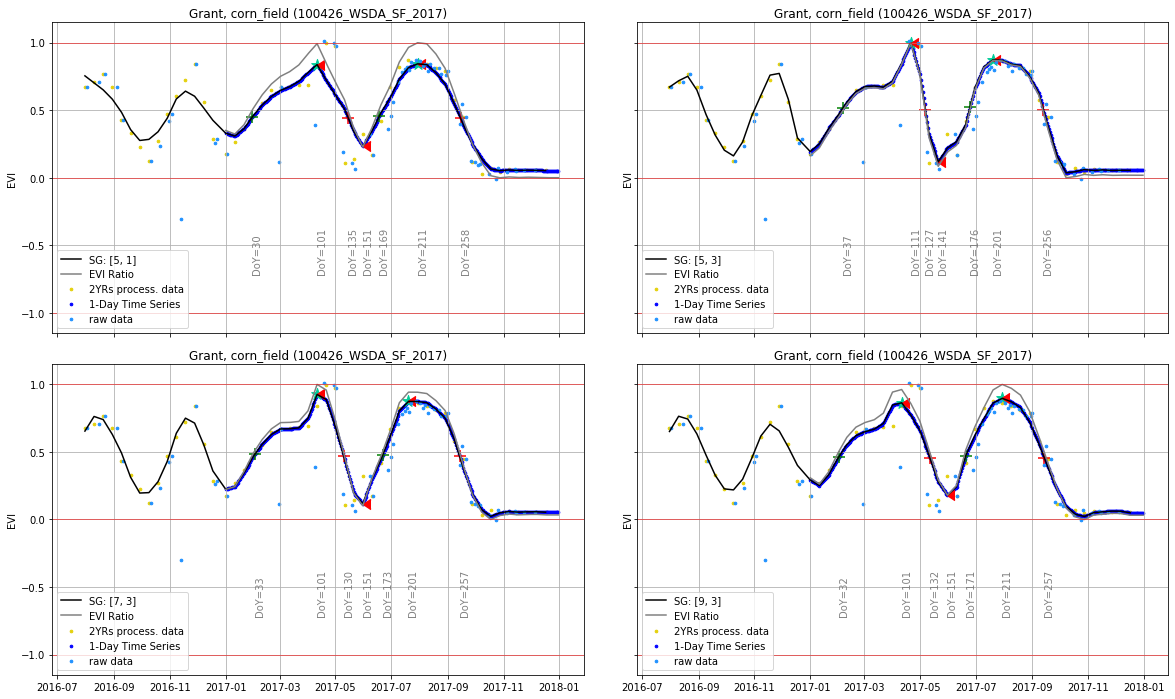

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = one_field,
                                                           twoYears_regular = clean_regularized_TS, 
                                                           idx=indeks, SG_params=[5, 1], 
                                                           SFYr=SF_year, ax=ax1, deltA=0.4);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = one_field,
                                                           twoYears_regular = clean_regularized_TS, 
                                                           idx=indeks, 
                                                           SG_params=[5, 3], 
                                                           SFYr=SF_year, ax=ax2, deltA=0.4); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = one_field,
                                                           twoYears_regular = clean_regularized_TS, 
                                                           idx=indeks, SG_params=[7, 3], 
                                                           SFYr=SF_year, ax=ax3, deltA=0.4);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(twoYears_raw = one_field,
                                                           twoYears_regular = clean_regularized_TS, 
                                                           idx=indeks, SG_params=[9, 3],
                                                           SFYr=SF_year, ax=ax4, deltA=0.4)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

# fig_name = plot_path + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
# plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

### (b) [Python Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html)



In [26]:
# crr_fld = clean_regularized_TS.copy()
# idx = indeks
# SG_params = [5, 1]
# SFYr = 2017
# ax = [0, 0]
# deltA = 0.4

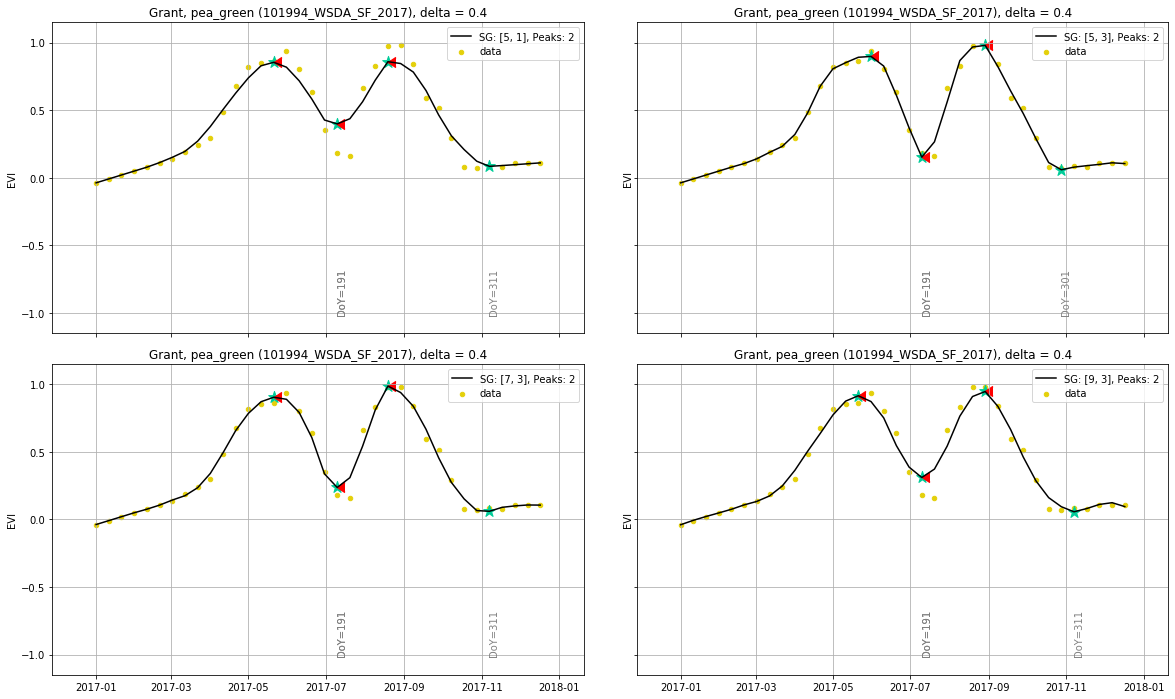

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[5, 1], 
                                                      SFYr=SF_year, ax=ax1, deltA=0.4);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[5, 3], 
                                                      SFYr=SF_year, ax=ax2, deltA=0.4); 

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[7, 3], 
                                                      SFYr=SF_year, ax=ax3, deltA=0.4);

rcp.savitzky_1yr_panels_clean_sciPy_and_My_PeakFinder(A_Data = clean_regularized_TS, 
                                                      idx=indeks, SG_params=[9, 3],
                                                      SFYr=SF_year, ax=ax4, deltA=0.4)

plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

# fig_name = plot_path + "SciPy_MATLAB_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
# plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

## 7. Find SOS and EOS using NDVI ratio of White 
and TIMESAT? finding min and max is already challenging. SOS and EOS depends in these two in TIMESAT.

#### Plot with onset and offset being equal

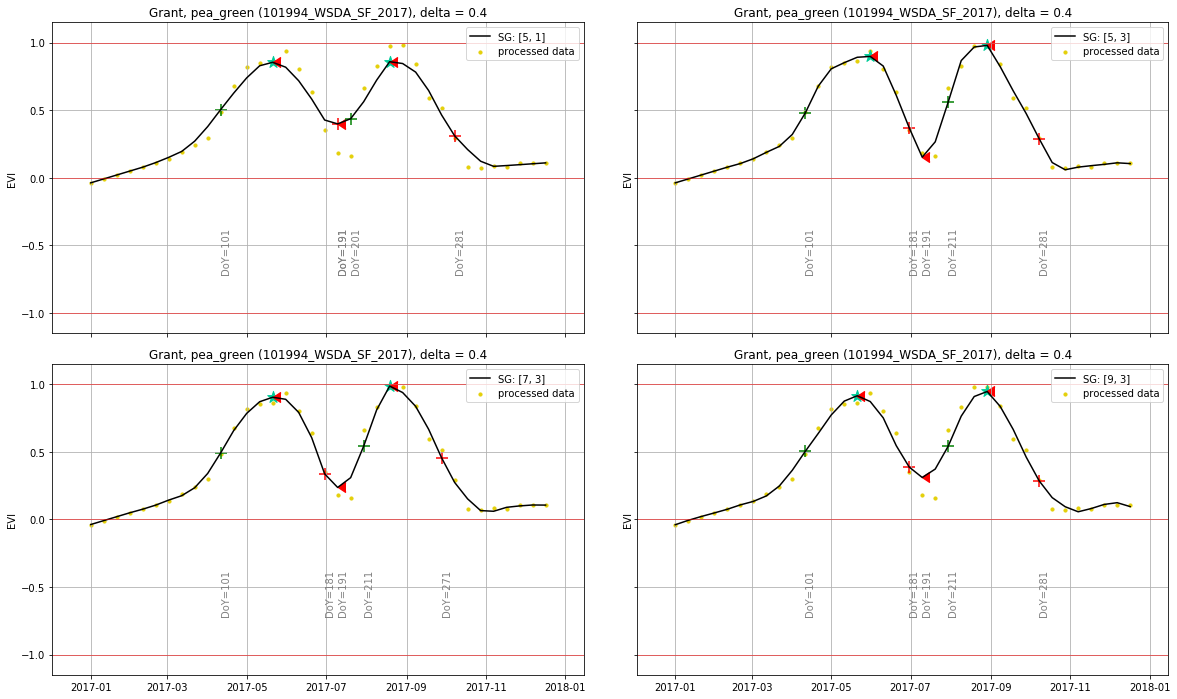

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

sos_thresh = 0.5
eos_thresh = 0.5

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, 
                                           SG_params=[5, 1], 
                                           SFYr=SF_year, ax=ax1, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=0.4,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "EqualOnOff_SciPy_MATLAB" + \
           county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + \
           '_sosCut_' + str(sos_thresh) + '.png'

plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

#### Plot with onset and offset being different

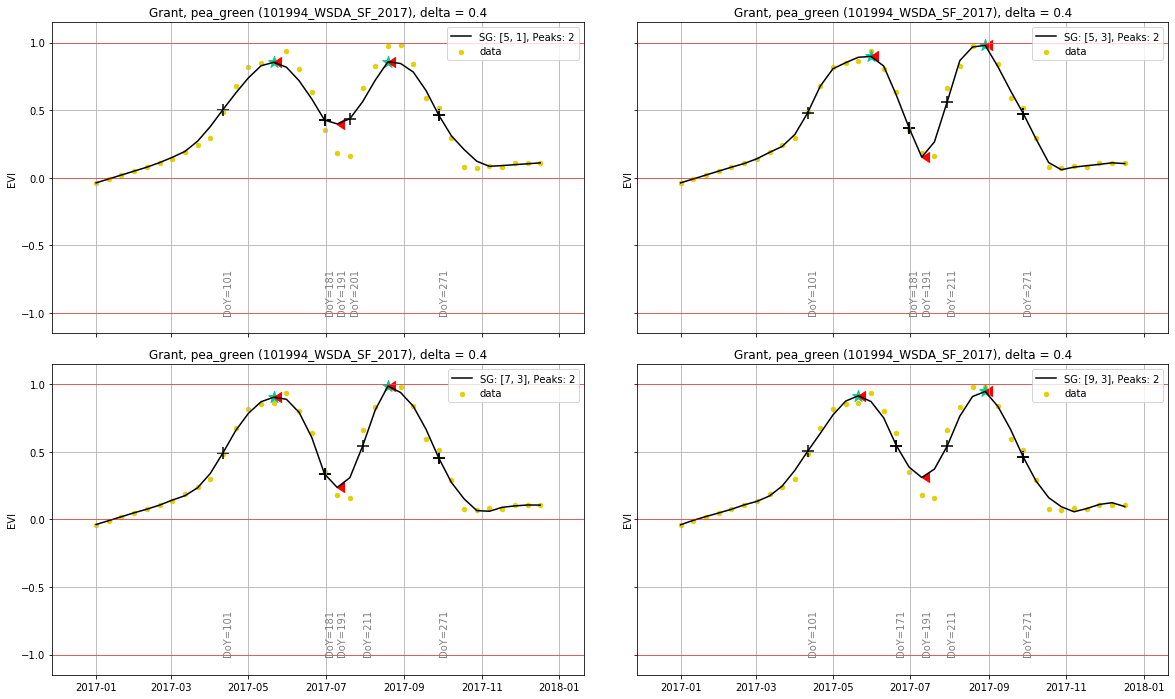

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, 
                                           SG_params=[5, 1], 
                                           SFYr=SF_year, ax=ax1, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS(dataAB = clean_regularized_TS, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=0.4,
                                           onset_cut=0.5, offset_cut=0.6)


plot_path = "/Users/hn/Desktop/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "DifferentOnOff_SciPy_MATLAB" + \
           county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=250, bbox_inches='tight')

In [ ]:
y = clean_regularized_TS.EVI.values.copy()
SG_pred = scipy.signal.savgol_filter(y, window_length= 7, polyorder=3)
clean_regularized_TS.EVI = SG_pred

In [ ]:
crr_fld = rc.addToDF_SOS_EOS_White(pd_TS = clean_regularized_TS, 
                                   VegIdx = "EVI", 
                                   onset_thresh = 0.5, 
                                   offset_thresh = 0.6)

In [ ]:
crr_fld[crr_fld.SOS.values != 0]

In [ ]:
number_of_rows = len(crr_fld)

SOS_indicator = np.zeros(number_of_rows)
EOS_indicator = np.zeros(number_of_rows)

SOS_indicator[np.where(crr_fld.SOS.values != 0)[0]] = 1
EOS_indicator[np.where(crr_fld.EOS.values != 0)[0]] = 1

In [ ]:
crr_fld.head(2)

# Plots for Sept Meeting

In [24]:
raw_EVI_time = one_field['Date'].copy()
raw_EVI_values = one_field['EVI'].copy()

# plot raw

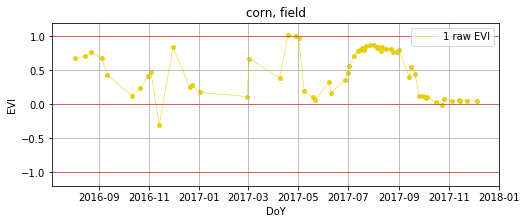

In [40]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

ax.plot(raw_EVI_time, 
        raw_EVI_values,
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time, 
           raw_EVI_values, 
           marker='o', 
           s=15, 
           c='#E4D00A')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0 , color = 'r', linewidth=.5)
ax.axhline(1 , color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "00_raw_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

# plot outlier removed, jump removed

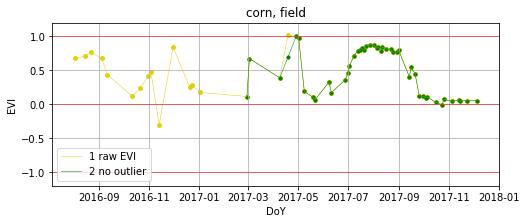

In [41]:
# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time, 
        raw_EVI_values, 
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time, 
           raw_EVI_values,
           marker='o', 
           s=15, 
           c='#E4D00A')

#
#  outlier removed
#
ax.plot(outlierRemoved_EVI_time[14:], 
        outlierRemoved_EVI_values[14:], 
        linewidth=.5, 
        c='g', 
        label="2 no outlier")

ax.scatter(outlierRemoved_EVI_time[14:], 
           outlierRemoved_EVI_values[14:], 
           marker='o', 
           s=10,
           c='g')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0 , color = 'r', linewidth=.5)
ax.axhline(1 , color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "01_raw_noOutlier_" + \
           county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'

plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

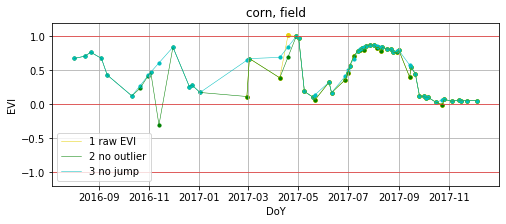

In [42]:
# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time[14:], 
        raw_EVI_values[14:], 
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time[14:], 
           raw_EVI_values[14:],
           marker='o', 
           s=15, 
           c='#E4D00A')

#
#  outlier removed
#
ax.plot(outlierRemoved_EVI_time, 
        outlierRemoved_EVI_values, 
        linewidth=.5, 
        c='g', 
        label="2 no outlier")

ax.scatter(outlierRemoved_EVI_time, 
           outlierRemoved_EVI_values, 
           marker='o', 
           s=10,
           c='g')

#
#  jump removed
#
ax.plot(outlierJumpRemoved_EVI_time, 
        outlierJumpRemoved_EVI_values, 
        linewidth=.5, 
        c='c', 
        label="3 no jump")

ax.scatter(outlierJumpRemoved_EVI_time, 
           outlierJumpRemoved_EVI_values, 
           marker='o', 
           s=10,
           c='c')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]


os.makedirs(plot_path, exist_ok=True)

fig_name = plot_path + "02_raw_Nojump_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

# plot regularized and gaps filled

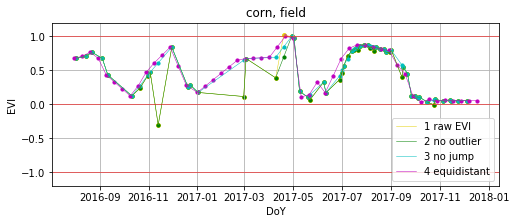

In [45]:
# regularized_EVI_values
# regularized_EVI_time

# filledGaps_EVI_values
# filledGaps_EVI_time

# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time,
        raw_EVI_values,
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time,
           raw_EVI_values,
           marker='o', 
           s=15, 
           c='#E4D00A')

#
#  outlier removed
#
ax.plot(outlierRemoved_EVI_time, 
        outlierRemoved_EVI_values, 
        linewidth=.5, 
        c='g', 
        label="2 no outlier")

ax.scatter(outlierRemoved_EVI_time,
           outlierRemoved_EVI_values,
           marker='o', 
           s=10,
           c='g')

#
#  jump removed
#
ax.plot(outlierJumpRemoved_EVI_time, 
        outlierJumpRemoved_EVI_values, 
        linewidth=.5, 
        c='c', 
        label="3 no jump")

ax.scatter(outlierJumpRemoved_EVI_time, 
           outlierJumpRemoved_EVI_values, 
           marker='o', 
           s=10,
           c='c')

#
#  regularized
#
ax.plot(filledGaps_EVI_time, 
        filledGaps_EVI_values, 
        linewidth=.5, 
        c='m', 
        label="4 equidistant")

ax.scatter(filledGaps_EVI_time, 
           filledGaps_EVI_values, 
           marker='o', 
           s=10,
           c='m')


ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "03_regularized_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

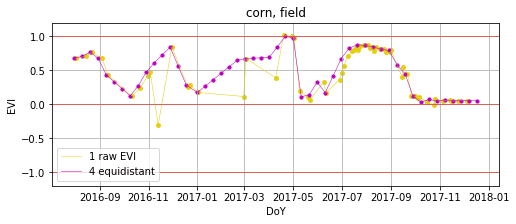

In [46]:
# regularized_EVI_values
# regularized_EVI_time

# filledGaps_EVI_values
# filledGaps_EVI_time

# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time, # [14:]
        raw_EVI_values,# [14:] 
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time, # [14:]
           raw_EVI_values,# [14:]
           marker='o', 
           s=15, 
           c='#E4D00A')
#
#  regularized
#
ax.plot(filledGaps_EVI_time,
        filledGaps_EVI_values,
        linewidth=.5, 
        c='m', 
        label="4 equidistant")

ax.scatter(filledGaps_EVI_time,
           filledGaps_EVI_values,
           marker='o', 
           s=10,
           c='m')


ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "04_Cleanregularized_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

In [47]:
y = clean_regularized_TS['EVI'].copy()
SG_pred = scipy.signal.savgol_filter(y, window_length= 7, polyorder=3)

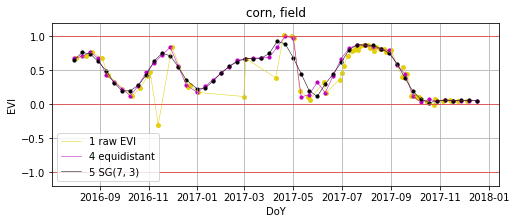

In [53]:
# regularized_EVI_values
# regularized_EVI_time

# filledGaps_EVI_values
# filledGaps_EVI_time

# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time, # [14:] 
        raw_EVI_values, # [14:]
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time, # [14:]
           raw_EVI_values, # [14:]
           marker='o', 
           s=15, 
           c='#E4D00A')
#
#  regularized
#
ax.plot(filledGaps_EVI_time, # [14:]
        filledGaps_EVI_values,# [14:] 
        linewidth=.5, 
        c='m', 
        label="4 equidistant")

ax.scatter(filledGaps_EVI_time, 
           filledGaps_EVI_values, 
           marker='o', 
           s=10,
           c='m')

#
#  Smoothed
#
ax.plot(clean_regularized_TS['Date'], 
        SG_pred, 
        linewidth=.5, 
        c='k', 
        label="5 SG(7, 3)")

ax.scatter(clean_regularized_TS['Date'], 
           SG_pred,
           marker='o', 
           s=10,
           c='k')


ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "05_smooth_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

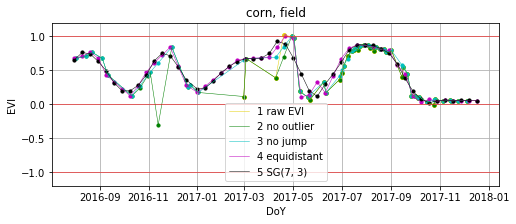

In [52]:
# regularized_EVI_values
# regularized_EVI_time

# filledGaps_EVI_values
# filledGaps_EVI_time

# outlierRemoved_EVI_values 
# outlierRemoved_EVI_time

# outlierJumpRemoved_EVI_values
# outlierJumpRemoved_EVI_time

fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
ax.plot(raw_EVI_time[14:], 
        raw_EVI_values[14:], 
        linewidth=.5, 
        c='#E4D00A', 
        label="1 raw EVI")

ax.scatter(raw_EVI_time[14:], 
           raw_EVI_values[14:],
           marker='o', 
           s=15, 
           c='#E4D00A')

#
#  outlier removed
#
ax.plot(outlierRemoved_EVI_time, 
        outlierRemoved_EVI_values, 
        linewidth=.5, 
        c='g', 
        label="2 no outlier")

ax.scatter(outlierRemoved_EVI_time, 
           outlierRemoved_EVI_values, 
           marker='o', 
           s=10,
           c='g')

#
#  jump removed
#
ax.plot(outlierJumpRemoved_EVI_time, 
        outlierJumpRemoved_EVI_values, 
        linewidth=.5, 
        c='c', 
        label="3 no jump")

ax.scatter(outlierJumpRemoved_EVI_time, 
           outlierJumpRemoved_EVI_values, 
           marker='o', 
           s=10,
           c='c')

#
#  regularized
#
ax.plot(filledGaps_EVI_time, 
        filledGaps_EVI_values, 
        linewidth=.5, 
        c='m', 
        label="4 equidistant")

ax.scatter(filledGaps_EVI_time, 
           filledGaps_EVI_values, 
           marker='o', 
           s=10,
           c='m')

#
#  Smoothed
#
ax.plot(clean_regularized_TS['Date'], 
        SG_pred, 
        linewidth=.5, 
        c='k', 
        label="5 SG(7, 3)")

ax.scatter(clean_regularized_TS['Date'], 
           SG_pred,
           marker='o', 
           s=10,
           c='k')


ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "06_allSteps_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')

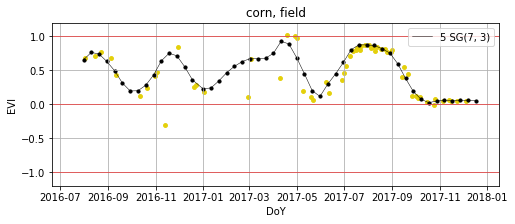

In [51]:
fig, ax = plt.subplots(figsize=(8,3));
plot_title = cleaned_field.CropTyp.unique()[0]

#
#  raw
#
# ax.plot(raw_EVI_time[14:], 
#         raw_EVI_values[14:], 
#         linewidth=.5, 
#         c='#E4D00A', 
#         label="1 raw EVI")

ax.scatter(raw_EVI_time,
           raw_EVI_values,
           marker='o', 
           s=15, 
           c='#E4D00A')

#
#  Smoothed
#
ax.plot(clean_regularized_TS['Date'], 
        SG_pred, 
        linewidth=.5, 
        c='k', 
        label="5 SG(7, 3)")

ax.scatter(clean_regularized_TS['Date'], 
           SG_pred,
           marker='o', 
           s=10,
           c='k')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)
ax.set_ylim([-1.2, 1.2])

ax.axhline(0, color = 'r', linewidth=.5); 
ax.axhline(1, color = 'r', linewidth=.5)
ax.axhline(-1, color = 'r', linewidth=.5)

######
plot_path = "/Users/hn/Desktop/remote_meeting/"
plant = clean_regularized_TS.CropTyp.unique()[0]
county = clean_regularized_TS.county.unique()[0]
ID = clean_regularized_TS.ID.unique()[0]

fig_name = plot_path + "07_rawSmooth_" + county + "_" + plant + "_SF_year_" + str(SF_year) + "_" + ID + '.png'
plt.savefig(fname = fig_name, dpi=600, bbox_inches='tight')